# Comparison between our results and the Octopus paper

In [1]:
import pdb, os
from natsort import natsorted 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import gspread
from tqdm import tqdm
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
def pdiff(x1, x2):
    x1 = np.array(x1) 
    x2 = np.array(x2) 
    x3 = x1.copy()
    x3[x3 == 0] = 1 # handle divide by 0
    return ((x2 - x1) / x3) * 100

This notebook provides a comparison between our results and the results of the Octopus joint-control paper. Any differences between the two approaches will also be highlighted in this notebook, and major implementation details will be outlined.

### Octopus Implementation details

* #### 1\. State Space (each variable also include n historical time steps** can't find value for n in paper): 
    * 1.1\. Outdoor Temperature
    * 1.2\. Outdoor Relative Humidity
    * 1.3\. Indoor Air Temperature
    * 1.4\. Outdoor Air Relative Humidity
    * 1.5\. Diffuse Solar Radiation
    * 1.6\. Direct Solar Radiation
    * 1.7\. Solar Incident Angle
    * 1.8\. Wind Spped
    * 1.9\. Wind Direction
    * 1.10\. Average PMV
    * 1.11\. Heating Setpoint of HVAC System
    * 1.12\. Cooling Setpoint of HVAC SYstem
    * 1.13\. Dimming Level of Lights
    * 1.14\. Window Open Percentage
    * 1.15\. Blind Open Angle

* #### 2\. Action Space (Discrete, ranges not specified):
    * 2.1\. Temperature setpoint of HVAC system (66 values)
    * 2.2\. Dimming level of electric lights (33 values)
    * 2.3\. Blind slat angle (33 values)
    * 2.4\. Open Percentage of Windows (33 values)
    
* #### 3\. Reward (Cannot find the penalty ranges in the paper. Not sure how to find Lagrangian Multipliers):
    \\( R = -[\rho_1 Norm(E) + \rho_1 Norm(T_c) + \rho_1 Norm(V_c) + \rho_1 Norm(I_c) ] \\)
    
    where
    
    \\( Norm(x) = (x - x_{min})/(x - x_{max}) \\), and \\(\rho\\)'s are Langrangian multipliers,
    
    \\( E = (P_{heatingCoil} + P_{coolingCoil} + P_{fan} + P_{lights}) \\),        (Energy Comsumption)
    
    \\( T_c = 0\\) if in range, else penalty,        (Thermal Comfort)
    
    \\( V_c = 0\\), if in range, else pentaly,       (Visual Comfort)
    
    \\( I_c = 0\\), if in range, else penalty,      (Indoor Air Quality)
    
* #### 3\. Metrics (It is unclear whether this is considered only for occupied periods): 
    * Reported in terms of violation rates of the above values. Violation rate is the time when the value of a human comfort metrics falls beyond acceptable range, divided by total simulation time.
    
* #### 4\. Data and Training 
    * TODO

## Octopus Results

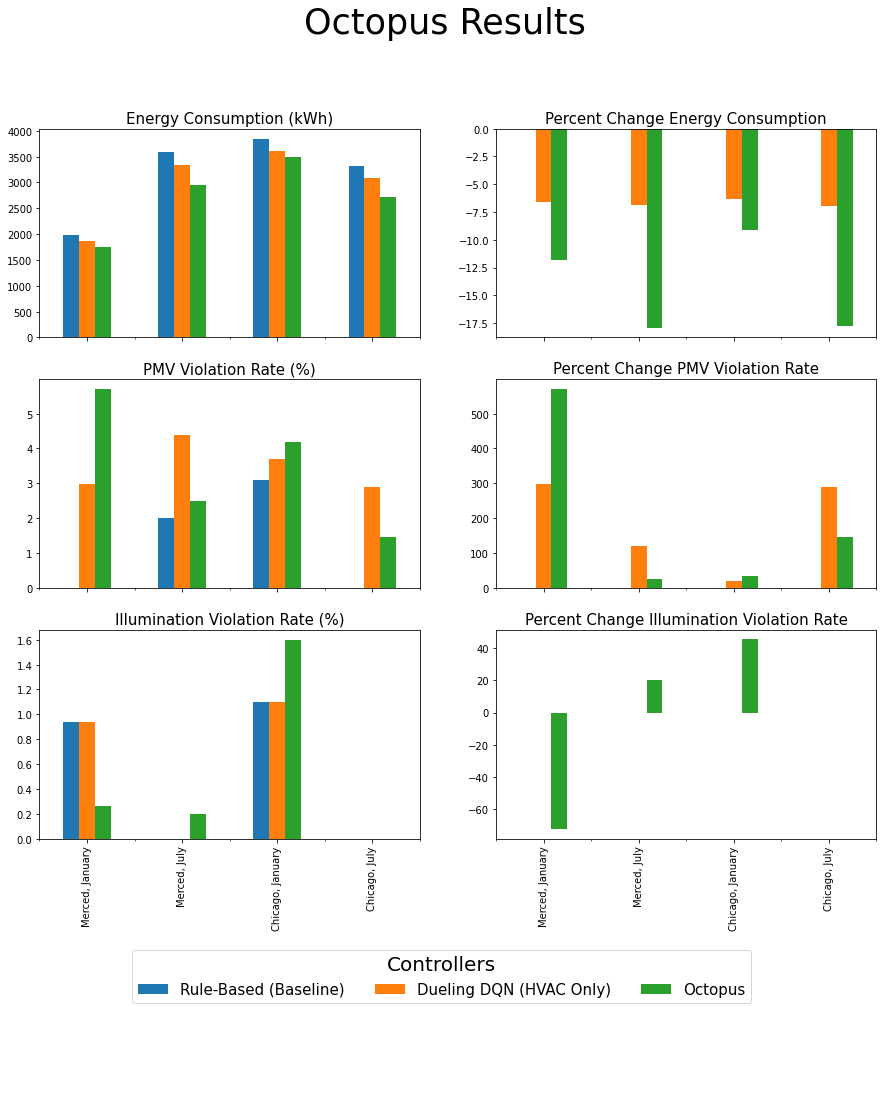

In [3]:
# idx = ['Rule-Based (Baseline)', 'Dueling DQN (HVAC Only)', 'Octopus']
idx = ['Merced, January', 'Merced, July', 'Chicago, January', 'Chicago, July']

e_baseline = [1990.99, 3583.03, 3848.61, 3309.56] 
pmv_mbaseline = [0.03, 0.25, 0.28, 0.15]
pmv_vbaseline = [0, 2, 3.09, 0]
illum_mbaseline = [576.78, 646.45, 583.27, 637.07]
illum_vbaseline = [0.94, 0, 1.1, 0]

energy_consumption = pd.DataFrame({
    'Rule-Based (Baseline)': e_baseline,
    'Dueling DQN (HVAC Only)': [1859.10, 3335.58, 3605.21, 3078.67],
    'Octopus': [1756.24, 2941.46, 3496.54, 2722.03],
}, index=idx)
pmv_mean = pd.DataFrame({
    'Rule-Based (Baseline)': pmv_mbaseline,
    'Dueling DQN (HVAC Only)': [0.19, 0.28, 0.32, 0.24],
    'Octopus': [0.31, 0.27, 0.4, 0.29],
}, index=idx)
pmv_viol = pd.DataFrame({
    'Rule-Based (Baseline)': pmv_vbaseline,
    'Dueling DQN (HVAC Only)': [2.99, 4.4, 3.7, 2.9],
    'Octopus': [5.7, 2.5, 4.2, 1.47],
}, index=idx)
illum_mean = pd.DataFrame({
    'Rule-Based (Baseline)': illum_mbaseline,
    'Dueling DQN (HVAC Only)': [576.78, 646.45, 583.27, 637.07],
    'Octopus': [587.12, 569.88, 598.34, 544.09],
}, index=idx)
illum_viol = pd.DataFrame({
    'Rule-Based (Baseline)': illum_vbaseline,
    'Dueling DQN (HVAC Only)': [0.94, 0, 1.1, 0],
    'Octopus': [0.26, 0.2, 1.6, 0],
}, index=idx)


pdiff_energy_consumption = pd.DataFrame({
    'Rule-Based (Baseline)': [0,0,0,0],
    'Dueling DQN (HVAC Only)': pdiff(e_baseline, [1859.10, 3335.58, 3605.21, 3078.67]),
    'Octopus':  pdiff(e_baseline, [1756.24, 2941.46, 3496.54, 2722.03]),
}, index=idx)
pdiff_pmv_mean = pd.DataFrame({
    'Rule-Based (Baseline)': [0,0,0,0],
    'Dueling DQN (HVAC Only)':  pdiff(pmv_mbaseline, [0.19, 0.28, 0.32, 0.24]),
    'Octopus':  pdiff(pmv_mbaseline, [0.31, 0.27, 0.4, 0.29]),
}, index=idx)
pdiff_pmv_viol = pd.DataFrame({
    'Rule-Based (Baseline)': [0,0,0,0],
    'Dueling DQN (HVAC Only)':  pdiff(pmv_vbaseline, [2.99, 4.4, 3.7, 2.9]),
    'Octopus':  pdiff(pmv_vbaseline, [5.7, 2.5, 4.2, 1.47]),
}, index=idx)
pdiff_illum_mean = pd.DataFrame({
    'Rule-Based (Baseline)': [0,0,0,0],
    'Dueling DQN (HVAC Only)':  pdiff(illum_mbaseline, [576.78, 646.45, 583.27, 637.07]),
    'Octopus':  pdiff(illum_mbaseline, [587.12, 569.88, 598.34, 544.09]),
}, index=idx)
pdiff_illum_viol = pd.DataFrame({
    'Rule-Based (Baseline)': [0,0,0,0],
    'Dueling DQN (HVAC Only)':  pdiff(illum_vbaseline, [0.94, 0, 1.1, 0]),
    'Octopus':  pdiff(illum_vbaseline, [0.26, 0.2, 1.6, 0]),
}, index=idx)


fig, axes = plt.subplots(3,2, figsize=(15,17), sharex=True)
plt.suptitle('Octopus Results', fontsize=35)

l1 = energy_consumption.plot(kind='bar', ax=axes[0,0]);
axes[0,0].get_legend().remove()
axes[0,0].set_title('Energy Consumption (kWh)', fontsize=15)
l1 = pdiff_energy_consumption.plot(kind='bar', ax=axes[0,1]);
axes[0,1].get_legend().remove()
axes[0,1].set_title('Percent Change Energy Consumption', fontsize=15)

# l2 = pmv_mean.plot(kind='bar', ax=axes[1,0]);
# axes[1,0].get_legend().remove()
# axes[1,0].set_title('Mean PMV (Absolute Value)')
# l2 = pdiff_pmv_mean.plot(kind='bar', ax=axes[1,1]);
# axes[1,1].get_legend().remove()
# axes[1,1].set_title('Percent Change\nMean PMV')

l3 = pmv_viol.plot(kind='bar', ax=axes[1,0]);
axes[1,0].get_legend().remove()
axes[1,0].set_title('PMV Violation Rate (%)', fontsize=15)
l3 = pdiff_pmv_viol.plot(kind='bar', ax=axes[1,1]);
axes[1,1].get_legend().remove()
axes[1,1].set_title('Percent Change PMV Violation Rate', fontsize=15)

# l4 = illum_mean.plot(kind='bar', ax=axes[2,0]);
# axes[2,0].get_legend().remove()
# axes[2,0].set_title('Mean Illumination (lux)')
# l4 = pdiff_illum_mean.plot(kind='bar', ax=axes[2,1]);
# axes[2,1].get_legend().remove()
# axes[2,1].set_title('Percent Change\nMean Illumination')

l5 = illum_viol.plot(kind='bar', ax=axes[2,0]);
axes[2,0].get_legend().remove()
axes[2,0].set_title('Illumination Violation Rate (%)', fontsize=15)
l5 = pdiff_illum_viol.plot(kind='bar', ax=axes[2,1]);
axes[2,1].get_legend().remove()
axes[2,1].set_title('Percent Change Illumination Violation Rate', fontsize=15)


lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(
    lines, labels, 
    loc = 'lower center', 
    ncol=3, fontsize=15, 
    title_fontsize=20, 
    title="Controllers",
    borderaxespad=7.
);
fig.subplots_adjust(bottom=0.3)

In [4]:
energy_consumption

,Rule-Based (Baseline),Dueling DQN (HVAC Only),Octopus
"Merced, January",1990.99,1859.10,1756.24
"Merced, July",3583.03,3335.58,2941.46
"Chicago, January",3848.61,3605.21,3496.54
"Chicago, July",3309.56,3078.67,2722.03


### Our Implementation details

* #### 1\. State Space (Current): 
    * 1.1\. Current
        * 1.1.1 \. Indoor Temperature
    * 1.2\. Forecasted
        * 1.2.1\. Outdoor Temp
        * 1.2.2\. Total Rad.
        * 1.2.3\. Occupancy Flag

    * #### State Space (change to this later): 
        * 1.1\. Current
            * 1.1.1 \. Indoor Temperature
            * 1.1.2 \. Average PMV
            * 1.1.2 \. Blind Open Angle
        * 1.2\. Forecasted
            * 1.2.1\. Outdoor Temp
            * 1.2.2\. Diffuse Solar Radiation
            * 1.2.3\. Direct Solar Radiation
            * 1.2.4\. Outdoor Relative Humidity
            * 1.2.5\. Outdoor Air Relative Humidity
            * 1.2.6\. Solar Incident Angle
            * 1.2.7\. Wind Speed
            * 1.2.8\. Wind Direction
            * 1.2.9\. Occupancy Flag
            * 1.2.10\. Setpoint of HVAC System
        

* #### 2\. Action Space (Discrete, ranges not specified):
    * 2.1\. Temperature setpoint of HVAC system (Continuous)
    * 2.2\. Blind slat angle (Continuous)
    
* #### 3\. Reward (Cannot find the penalty ranges in the paper. Not sure how to find Lagrangian Multipliers):
    \\( R = -[\rho_1 Norm(E) + \rho_1 Norm(T_c) + \rho_1 Norm(V_c) + \rho_1 Norm(I_c) ] \\)
    
    where
    
    \\( Norm(x) = (x - x_{min})/(x - x_{max}) \\), and \\(\rho\\)'s are Langrangian multipliers,
    
    \\( E = (P_{heatingCoil} + P_{coolingCoil} + P_{fan} + P_{lights}) \\),        (Energy Comsumption)
    
    \\( T_c = 0\\) if in range, else penalty,        (Thermal Comfort)
    
    \\( V_c = 0\\), if in range, else pentaly,       (Visual Comfort)
    
    \\( I_c = 0\\), if in range, else penalty,      (Indoor Air Quality)
    
* #### 3\. Metrics (It is unclear whether this is considered only for occupied periods): 
    * Reported in terms of violation rates of the above values. Violation rate is the time when the value of a human comfort metrics falls beyond acceptable range, divided by total simulation time.
    
* #### 4\. Data and Training 
    * TODO
    
##### Major Differences
1. Past observations vs forecasting
2. Using 1st state space list right now, which is quite different
3. Not including window open slat or light level in actions
4. CO2 level not included in reward
5. Light power not included in reward
6. Only including comfort metrics when the building is occupied
7. Only controlling blinds in 1 room for now

## Our Results

In [5]:
DUELING_ROOT = '<REMOVED>'
SAC_ROOT = '<REMOVED>'
PPO_ROOT = '<REMOVED>'

In [8]:
def load_baseline(pth):
    baseline = pd.read_csv(f'../baselines/{pth}.csv', index_col='time')
    baseline.index = pd.to_datetime(baseline.index)
    if 'heating' in pth:
        baseline = baseline['1991-01-01 00:15:00':'1991-02-01 23:45:00']
    else:
        baseline = baseline['1991-07-01 00:15:00':'1991-08-02 00:00:00']

    hvac = baseline['HVAC Power'].sum()
    lights = baseline['Lights Zone 1'].sum()
    baseline['PMV'] = (baseline['PMV Zone 1'] + baseline['PMV Zone 2'] + baseline['PMV Zone 3'] + baseline['PMV Zone 4'] + baseline['PMV Zone 5']) / 5
    
    comfort = baseline[baseline["Occupancy Flag"]==1].copy()
    pmv_mean = comfort["PMV"].mean()
    pmv_viol = (len(comfort[abs(comfort["PMV"]) > 0.7]) / len(comfort)) * 100
    illum_mean = ((comfort['Illuminance 1'] + comfort['Illuminance 2']) / 2).mean()
    ill = (comfort['Illuminance 1'] + comfort['Illuminance 2']) / 2
    illum_viol = len(ill[(ill < 300) | (ill > 750)]) /len(comfort)

    return hvac + lights, pmv_mean, pmv_viol, illum_mean, illum_viol * 100, baseline

def load_result(pth, no_output=False):
    if 'sac' in pth.lower():
        root = os.path.join(SAC_ROOT, 'rl_results', pth)
    elif 'dueling' in pth.lower():
        root = os.path.join(DUELING_ROOT, 'rl_results', pth)
    elif 'ppo' in pth.lower():
        root = os.path.join(PPO_ROOT, 'rl_results', pth)
    else:
        raise ValueError('bad agent type')
        
#     x = os.listdir(root)
#     x = [i for i in x if 'csv' in i]
#     x = natsorted(x)
#     if len(x) > 1:
#         csv = x[-1]
#     else: 
#         raise ValueError(f'No results in directory {pth}')
    csv = "run_4.csv"
    pth = os.path.join(root, csv)
    
#     if os.path.isfile(os.path.join(root, "run_last.csv")):
#         return 1, 1
    
    if not no_output:
        print('loading', pth)
#     print(pd.read_csv(pth, index_col='time'))
#     print(x)
 
    if os.path.isfile(pth):
        df = pd.read_csv(pth, index_col='time')
    else:
        print(f"Error on reading {pth}. This run might failed/terminated before 400 episodes.")
        return

    df.index = pd.to_datetime(df.index)
    
    
#     if 'heating' in name:
#         occ_df = pd.read_csv(f'../baselines/heating_occ.csv')
#         occ_df.index = pd.to_datetime(occ_df.time)
#         occ_df = occ_df['1991-01-01 00:15:00':'1991-02-02 00:00:00']
#     else:
#         occ_df = pd.read_csv(f'../baselines/cooling_occ.csv')
#         occ_df.index = pd.to_datetime(occ_df.time)
#         occ_df = occ_df['1991-07-01 00:15:00':'1991-08-02 00:00:00']

#     df = pd.concat([df, occ_df.reindex(df.index)], axis=1, sort=False)
    
    df = df.fillna(0.0)
    
    df['Illum Zone 1'] = (df['Illum 1 Zone 1'] + df['Illum 2 Zone 1']) / 2
    df['Illum Zone 3'] = (df['Illum 1 Zone 3'] + df['Illum 2 Zone 3']) / 2
    
    hvac = df['HVAC Power'].sum() 
    lights = (df['Lights Zone 1'] + df['Lights Zone 2'] + df['Lights Zone 3'] + df['Lights Zone 4']).sum() 
    
    df['Illum'] = np.zeros(df.shape[0])
    df['PMV'] = np.zeros(df.shape[0])
    
    if 'customOccTrue' in name:
#         for i in range(1, 6):
#             occ_col = f'SPACE{i}-1 Occupied'
#             df.loc[df[occ_col] > 0, occ_col] = 1
#             df.loc[df[occ_col] == 0, f'PMV Zone {i}'] = 0
#             df.loc[df[occ_col] == 0, f'Illum Zone {i}'] = 500

        df['Occupied Edges'] = np.zeros(df.shape[0])
        for i in range(1, 5):
            occupied = df[f'Occu Zone {i}'] > 0
            df['Occupied Edges'] = df['Occupied Edges'] + occupied
            df[f'Illum Zone {i}'] = np.maximum(500, df[f'Illum Zone {i}'].values)
            df['Illum'] = df['Illum'] + df[f'Illum Zone {i}'] * occupied
            df['PMV'] = df['PMV'] + abs(df[f'PMV Zone {i}']) * occupied
        edges_cnt = (df['Occupied Edges'] > 0).sum()
        
        df['Occupied All'] = df['Occupied Edges'] + (df['Occu Zone 5'] > 0)
        df['PMV'] = df['PMV'] + abs(df['PMV Zone 5']) * (df['Occu Zone 5'] > 0)
        all_cnt = (df['Occupied All'] > 0).sum()
        
        # if not occupied, divide by total so that it lands ina a rnage that isn't a violation.
        df['Occupied Edges'] = df['Occupied Edges'].replace(0, 10)
        df['Occupied All'] = df['Occupied All'].replace(0, 10)
        
        df['Illum'] = df['Illum'] / df['Occupied Edges']
        df['PMV'] = df['PMV'] / df['Occupied All']
        
        df['Occupied Edges'] = df['Occupied Edges'].replace(10, 0)
        df['Occupied All'] = df['Occupied All'].replace(10, 0)
        
        pmv_viol = (abs(df[df['Occupied All'] > 0]["PMV"]) > 0.7).sum() / all_cnt
        illum_viol = (abs(df[df['Occupied Edges'] > 0]['Illum'] - 500) > 250).sum() / edges_cnt
        
        illum_mean = df[df['Occupied Edges'] > 0]['Illum'].mean()
        pmv_mean = df[df['Occupied All'] > 0]['PMV'].mean()
    else:
        df["Occupancy Flag"] = np.zeros(df.shape[0])
        for i in range(1, 6):
            df["Occupancy Flag"] = df["Occupancy Flag"] + df[f'Occu Zone 5']
        comfort = df[df["Occupancy Flag"] >= 1].copy()
        for i in range(1, 6):
            comfort['PMV'] = comfort['PMV'] + abs(comfort[f'PMV Zone {i}'])
            if i != 5:
                comfort['Illum'] = comfort['Illum'] + np.maximum(500, comfort[f'Illum Zone {i}'].values)
            
        comfort['PMV'] = comfort['PMV'] / 5
        comfort['Illum'] = comfort['Illum'] / 4
        pmv_viol = (abs(comfort["PMV"]) > 0.7).sum() / comfort.shape[0]
#         ill = comfort[['Illum 1 Zone 1', 'Illum 2 Zone 1', 'Illum 1 Zone 3', 'Illum 2 Zone 3', 'Illum Zone 2', 'Illum Zone 4']].mean(axis=1)
        illum_viol = (abs(comfort['Illum'] - 500) > 250).sum() / comfort.shape[0]
        
        illum_mean = comfort['Illum'].mean()
        pmv_mean = comfort['PMV'].mean()
    
    return hvac + lights, pmv_mean, pmv_viol * 100, illum_mean, illum_viol * 100, df


In [9]:
data = dict()
current_model = "PPO"

if current_model == "PPO":
    result_root = PPO_ROOT
elif current_model == "SAC":
    result_root = SAC_ROOT
else:
    result_root = DUELING_ROOT

    
unique_options = list()
pbar = tqdm(glob.glob(f"{result_root}/rl_results/**"))
for path in pbar:
    name = path[path.rfind('/') + 1:]
#     if name[0] == 'S':
    if current_model in name:
        tag = name.split('_')
        label = f"{tag[3][len(tag[3])-3:]} ({tag[5]} {tag[2]} {tag[6]} {tag[7][1:]} {'-'.join(tag[10:])})"
        pbar.set_description(f"Processing: {label:80s}")
        label_config = label[5:-1].split(' ')
        if len(unique_options) == 0:
            for i in range(len(label_config)):
                unique_options.append(set())
                
        for i in range(len(label_config)):
            unique_options[i].add(label_config[i])
        try:
            data[label] = load_result(name, no_output=True)
        except ValueError as e:
            print(e)
pbar.close()
for i in range(len(unique_options)):
    unique_options[i] = sorted(list(unique_options[i]))

Processing: PPO (heating customOccFalse blindsTrueMultiTrue lightingTrue 0.7-0.1-0.4)       : 100%|██████████| 1536/1536 [00:53<00:00, 28.81it/s]


In [29]:
h_df = load_baseline('stptCntrl_heating_blindsFalse_daylightingFalse')
hd_df = load_baseline('stptCntrl_heating_blindsFalse_daylightingFalse')
hb_df = load_baseline('stptCntrl_heating_blindsTrue_daylightingFalse')
hbd_df = load_baseline('stptCntrl_heating_blindsTrue_daylightingFalse')

c_df = load_baseline('stptCntrl_cooling_blindsFalse_daylightingFalse')
cd_df = load_baseline('stptCntrl_cooling_blindsFalse_daylightingFalse')
cb_df = load_baseline('stptCntrl_cooling_blindsTrue_daylightingFalse')
cbd_df = load_baseline('stptCntrl_cooling_blindsTrue_daylightingFalse')

In [30]:
idx = ['January', 'July']


e_baseline = [h_df[0], c_df[0]]
pmv_mbaseline = [abs(h_df[1]), abs(c_df[1])]
pmv_vbaseline = [h_df[2], c_df[2]]
illum_mbaseline = [h_df[3], c_df[3]]
illum_vbaseline = [h_df[4], c_df[4]]


energy_consumption = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': e_baseline,
    'Rule-Based (no blinds, with daylighting)': [hd_df[0], cd_df[0]],
    'Rule-Based (with blinds, no daylighting)': [hb_df[0], cb_df[0]],
    'Rule-Based (with blinds, with daylighting)': [hbd_df[0], cbd_df[0]],
    '': [0, 0]
}, index=idx)

pmv_mean = pd.DataFrame({
    'Rule-Based (no blinds)': pmv_mbaseline,
    'Rule-Based (with blinds)': [abs(hb_df[1]), abs(cb_df[1])],
    'Rule-Based (with blinds, no daylighting)': [abs(hb_df[1]), abs(cb_df[1])],
    'Rule-Based (with blinds, with daylighting)': [abs(hbd_df[1]), abs(cbd_df[1])],
    '': [0, 0]
}, index=idx)

pmv_viol = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': pmv_vbaseline,
    'Rule-Based (no blinds, with daylighting)': [hd_df[2], cd_df[2]],
    'Rule-Based (with blinds, no daylighting)': [hb_df[2], cb_df[2]],
    'Rule-Based (with blinds, with daylighting)': [hbd_df[2], cbd_df[2]],
    '': [0, 0]
}, index=idx)

illum_mean = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': illum_mbaseline,
    'Rule-Based (no blinds, with daylighting)': [hd_df[3], cd_df[3]],
    'Rule-Based (with blinds, no daylighting)': [hb_df[3], cb_df[3]],
    'Rule-Based (with blinds, with daylighting)': [hbd_df[3], cbd_df[3]],
    '': [0, 0]
}, index=idx)

illum_viol = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': illum_vbaseline,
    'Rule-Based (no blinds, with daylighting)': [hd_df[4], cd_df[4]],
    'Rule-Based (with blinds, no daylighting)': [hb_df[4], cb_df[4]],
    'Rule-Based (with blinds, with daylighting)': [hbd_df[4], cbd_df[4]],
    '': [0, 0]
}, index=idx)


pdiff_energy_consumption = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': [0, 0],
    'Rule-Based (no blinds, with daylighting)': pdiff(e_baseline, [hd_df[0], cd_df[0]]),
    'Rule-Based (with blinds, no daylighting)': pdiff(e_baseline, [hb_df[0], cb_df[0]]),
    'Rule-Based (with blinds, with daylighting)': pdiff(e_baseline, [hbd_df[0], cbd_df[0]]),
    '': [0, 0]
}, index=idx)

pdiff_pmv_mean = pd.DataFrame({
    'Rule-Based (no blinds)': [0, 0],
    'Rule-Based (with blinds)': pdiff(pmv_mbaseline, [abs(hb_df[1]), abs(cb_df[1])]),
    'Rule-Based (with blinds, no daylighting)': pdiff(pmv_mbaseline, [abs(hb_df[1]), abs(cb_df[1])]),
    'Rule-Based (with blinds, with daylighting)': pdiff(pmv_mbaseline, [abs(hbd_df[1]), abs(cbd_df[1])]),
    '': [0, 0]
}, index=idx)

pdiff_pmv_viol = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': pdiff(pmv_vbaseline, pmv_vbaseline),
    'Rule-Based (no blinds, with daylighting)': pdiff(pmv_vbaseline, [hd_df[2], cd_df[2]]),
    'Rule-Based (with blinds, no daylighting)': pdiff(pmv_vbaseline, [hb_df[2], cb_df[2]]),
    'Rule-Based (with blinds, with daylighting)': pdiff(pmv_vbaseline, [hbd_df[2], cbd_df[2]]),
    '': [0, 0]
}, index=idx)

pdiff_illum_mean = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': pdiff(illum_mbaseline, illum_mbaseline),
    'Rule-Based (no blinds, with daylighting)': pdiff(illum_mbaseline, [hd_df[3], cd_df[3]]),
    'Rule-Based (with blinds, no daylighting)': pdiff(illum_mbaseline, [hb_df[3], cb_df[3]]),
    'Rule-Based (with blinds, with daylighting)': pdiff(illum_mbaseline, [hbd_df[3], cbd_df[3]]),
    '': [0, 0]
}, index=idx)

pdiff_illum_viol = pd.DataFrame({
    'Rule-Based (no blinds, no daylighting)': pdiff(illum_vbaseline, illum_vbaseline),
    'Rule-Based (no blinds, with daylighting)': pdiff(illum_vbaseline, [hd_df[4], cd_df[4]]),
    'Rule-Based (with blinds, no daylighting)': pdiff(illum_vbaseline, [hb_df[4], cb_df[4]]),
    'Rule-Based (with blinds, with daylighting)': pdiff(illum_vbaseline, [hbd_df[4], cbd_df[4]]),
    '': [0, 0]
}, index=idx)

In [31]:
row_name = unique_options[-2][:]
for options in unique_options[-3::-1]:
    repeat = len(row_name)
    row_name *= len(options)
    for i, option in enumerate(options):
        for j in range(repeat):
            row_name[i * repeat + j] = f"{option} {row_name[i * repeat + j]}"

In [32]:
all_data = np.full([1 + len(row_name) * 10, 1 + len(unique_options[-1])], '', dtype=object)
all_data[0, 1:] = unique_options[-1]
all_data[1::10, 0] = row_name

In [33]:
for name in data:
    try:
        configs = name[5:-1].split(' ')
        row = row_name.index(' '.join(configs[:-1]))
        col = unique_options[-1].index(configs[-1])
        all_data[row * 10 + 1:row * 10 + 11, col + 1] = [data[name][0],
                                                         abs(data[name][1]),
                                                         data[name][2],
                                                         data[name][3],
                                                         data[name][4],
                                                         pdiff(e_baseline[configs[0] == 'cooling'], data[name][0]),
                                                         pdiff(pmv_mbaseline[configs[0] == 'cooling'], abs(data[name][1])),
                                                         pdiff(pmv_vbaseline[configs[0] == 'cooling'], data[name][2]),
                                                         pdiff(illum_mbaseline[configs[0] == 'cooling'], data[name][3]),
                                                         pdiff(illum_vbaseline[configs[0] == 'cooling'], data[name][4])]
    except TypeError:
        print(name)
        continue

In [34]:
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive.file",
         "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name('../utils/secret_info.json', scope)
client = gspread.authorize(creds).open("Result playground")

sheets = {"PPO": client.worksheet("ppo"),
          "SAC": client.worksheet("sac"),
          "DQN": client.worksheet("dqn")}

sheets[current_model].update("A1", all_data.tolist())

{'spreadsheetId': '1Xze1tgG_VTzeFhSLVBGV-LEgS6hcCdla9epPYh0j1Yc',
 'updatedRange': 'dqn!A1:BM121',
 'updatedRows': 121,
 'updatedColumns': 65,
 'updatedCells': 7865}

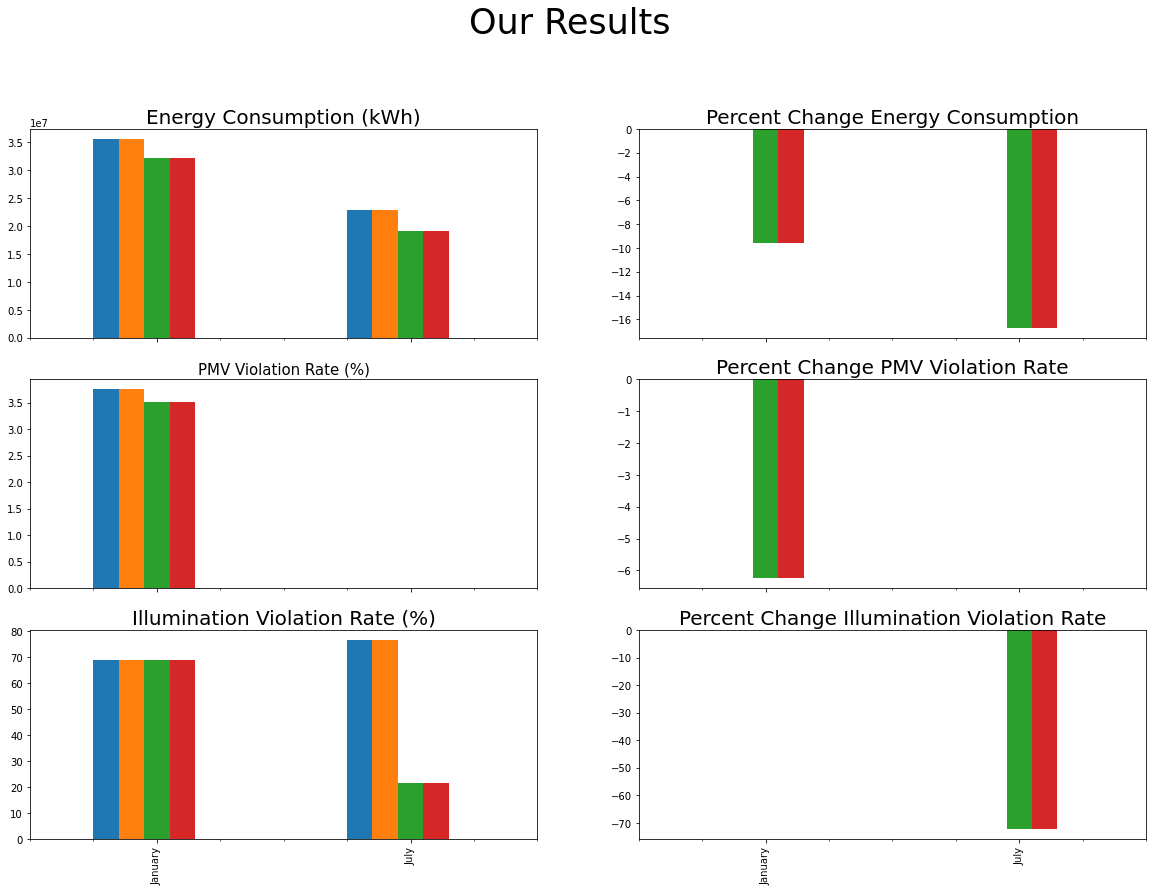

In [28]:
fig, axes = plt.subplots(3,2, figsize=(20,17), sharex=True)
plt.suptitle('Our Results', fontsize=35)


l1 = energy_consumption.plot(kind='bar', ax=axes[0,0]);
axes[0,0].get_legend().remove()
axes[0,0].set_title('Energy Consumption (kWh)', fontsize=20)


l1 = pdiff_energy_consumption.plot(kind='bar', ax=axes[0,1]);
axes[0,1].get_legend().remove()
axes[0,1].set_title('Percent Change Energy Consumption', fontsize=20)


l3 = pmv_viol.plot(kind='bar', ax=axes[1,0]);
axes[1,0].get_legend().remove()
axes[1,0].set_title('PMV Violation Rate (%)', fontsize=15)
l3 = pdiff_pmv_viol.plot(kind='bar', ax=axes[1,1]);
axes[1,1].get_legend().remove()
axes[1,1].set_title('Percent Change PMV Violation Rate', fontsize=20)


l5 = illum_viol.plot(kind='bar', ax=axes[2,0]);
axes[2,0].get_legend().remove()
axes[2,0].set_title('Illumination Violation Rate (%)', fontsize=20)
l5 = pdiff_illum_viol.plot(kind='bar', ax=axes[2,1]);
axes[2,1].get_legend().remove()
axes[2,1].set_title('Percent Change Illumination Violation Rate', fontsize=20)


# lines, labels = fig.axes[-1].get_legend_handles_labels()
# fig.legend(
#     lines[0:8] + lines[9:], labels[0:8] + labels[9:], 
#     loc = 'lower center', 
#     ncol=3, fontsize=15, 
#     title_fontsize=20, 
#     title="Controllers",
#     borderaxespad=7.
# );
fig.subplots_adjust(bottom=0.3)

In [ ]:
energy_consumption["test"] = [1, 2]
energy_consumption

# OLD PLOTS

### Octo results, including mean PMV and illumination

In [ ]:
# # idx = ['Rule-Based (Baseline)', 'Dueling DQN (HVAC Only)', 'Octopus']
# idx = ['Merced, January', 'Merced, July', 'Chicago, January', 'Chicago, July']

# e_baseline = [1990.99, 3583.03, 3848.61, 3309.56] 
# pmv_mbaseline = [0.03, 0.25, 0.28, 0.15]
# pmv_vbaseline = [0, 2, 3.09, 0]
# illum_mbaseline = [576.78, 646.45, 583.27, 637.07]
# illum_vbaseline = [0.94, 0, 1.1, 0]

# energy_consumption = pd.DataFrame({
#     'Rule-Based (Baseline)': e_baseline,
#     'Dueling DQN (HVAC Only)': [1859.10, 3335.58, 3605.21, 3078.67],
#     'Octopus': [1756.24, 2941.46, 3496.54, 2722.03],
# }, index=idx)
# pmv_mean = pd.DataFrame({
#     'Rule-Based (Baseline)': pmv_mbaseline,
#     'Dueling DQN (HVAC Only)': [0.19, 0.28, 0.32, 0.24],
#     'Octopus': [0.31, 0.27, 0.4, 0.29],
# }, index=idx)
# pmv_viol = pd.DataFrame({
#     'Rule-Based (Baseline)': pmv_vbaseline,
#     'Dueling DQN (HVAC Only)': [2.99, 4.4, 3.7, 2.9],
#     'Octopus': [5.7, 2.5, 4.2, 1.47],
# }, index=idx)
# illum_mean = pd.DataFrame({
#     'Rule-Based (Baseline)': illum_mbaseline,
#     'Dueling DQN (HVAC Only)': [576.78, 646.45, 583.27, 637.07],
#     'Octopus': [587.12, 569.88, 598.34, 544.09],
# }, index=idx)
# illum_viol = pd.DataFrame({
#     'Rule-Based (Baseline)': illum_vbaseline,
#     'Dueling DQN (HVAC Only)': [0.94, 0, 1.1, 0],
#     'Octopus': [0.26, 0.2, 1.6, 0],
# }, index=idx)


# pdiff_energy_consumption = pd.DataFrame({
#     'Rule-Based (Baseline)': [0,0,0,0],
#     'Dueling DQN (HVAC Only)': pdiff(e_baseline, [1859.10, 3335.58, 3605.21, 3078.67]),
#     'Octopus':  pdiff(e_baseline, [1756.24, 2941.46, 3496.54, 2722.03]),
# }, index=idx)
# pdiff_pmv_mean = pd.DataFrame({
#     'Rule-Based (Baseline)': [0,0,0,0],
#     'Dueling DQN (HVAC Only)':  pdiff(pmv_mbaseline, [0.19, 0.28, 0.32, 0.24]),
#     'Octopus':  pdiff(pmv_mbaseline, [0.31, 0.27, 0.4, 0.29]),
# }, index=idx)
# pdiff_pmv_viol = pd.DataFrame({
#     'Rule-Based (Baseline)': [0,0,0,0],
#     'Dueling DQN (HVAC Only)':  pdiff(pmv_vbaseline, [2.99, 4.4, 3.7, 2.9]),
#     'Octopus':  pdiff(pmv_vbaseline, [5.7, 2.5, 4.2, 1.47]),
# }, index=idx)
# pdiff_illum_mean = pd.DataFrame({
#     'Rule-Based (Baseline)': [0,0,0,0],
#     'Dueling DQN (HVAC Only)':  pdiff(illum_mbaseline, [576.78, 646.45, 583.27, 637.07]),
#     'Octopus':  pdiff(illum_mbaseline, [587.12, 569.88, 598.34, 544.09]),
# }, index=idx)
# pdiff_illum_viol = pd.DataFrame({
#     'Rule-Based (Baseline)': [0,0,0,0],
#     'Dueling DQN (HVAC Only)':  pdiff(illum_vbaseline, [0.94, 0, 1.1, 0]),
#     'Octopus':  pdiff(illum_vbaseline, [0.26, 0.2, 1.6, 0]),
# }, index=idx)


# fig, axes = plt.subplots(3,4, figsize=(15,12), sharex=True)

# l1 = energy_consumption.plot(kind='bar', ax=axes[0,0]);
# axes[0,0].get_legend().remove()
# axes[0,0].set_title('Energy Consumption (kWh)')
# l1 = pdiff_energy_consumption.plot(kind='bar', ax=axes[0,1]);
# axes[0,1].get_legend().remove()
# axes[0,1].set_title('Percent Change\nEnergy Consumption')

# l2 = pmv_mean.plot(kind='bar', ax=axes[1,0]);
# axes[1,0].get_legend().remove()
# axes[1,0].set_title('Mean PMV (Absolute Value)')
# l2 = pdiff_pmv_mean.plot(kind='bar', ax=axes[1,1]);
# axes[1,1].get_legend().remove()
# axes[1,1].set_title('Percent Change\nMean PMV')

# l3 = pmv_viol.plot(kind='bar', ax=axes[1,2]);
# axes[1,2].get_legend().remove()
# axes[1,2].set_title('PMV Violation Rate (%)')
# l3 = pdiff_pmv_viol.plot(kind='bar', ax=axes[1,3]);
# axes[1,3].get_legend().remove()
# axes[1,3].set_title('Percent Change\nPMV Violation Rate')

# l4 = illum_mean.plot(kind='bar', ax=axes[2,0]);
# axes[2,0].get_legend().remove()
# axes[2,0].set_title('Mean Illumination (lux)')
# l4 = pdiff_illum_mean.plot(kind='bar', ax=axes[2,1]);
# axes[2,1].get_legend().remove()
# axes[2,1].set_title('Percent Change\nMean Illumination')

# l5 = illum_viol.plot(kind='bar', ax=axes[2,2]);
# axes[2,2].get_legend().remove()
# axes[2,2].set_title('Illumination Violation Rate (%)')
# l5 = pdiff_illum_viol.plot(kind='bar', ax=axes[2,3]);
# axes[2,3].get_legend().remove()
# axes[2,3].set_title('Percent Change\nIllumination Violation Rate')


# lines, labels = fig.axes[-1].get_legend_handles_labels()
# fig.legend(lines, labels, loc = 'upper center')

### Our results, including mean PMV and illumination

In [ ]:
# fig, axes = plt.subplots(3,4, figsize=(15,12), sharex=True)

# l1 = energy_consumption.plot(kind='bar', ax=axes[0,0]);
# axes[0,0].get_legend().remove()
# axes[0,0].set_title('Energy Consumption (kWh)')
# l1 = pdiff_energy_consumption.plot(kind='bar', ax=axes[0,1]);
# axes[0,1].get_legend().remove()
# axes[0,1].set_title('Percent Change\nEnergy Consumption')

# l2 = pmv_mean.plot(kind='bar', ax=axes[1,0]);
# axes[1,0].get_legend().remove()
# axes[1,0].set_title('Mean PMV (Absolute Value)')
# l2 = pdiff_pmv_mean.plot(kind='bar', ax=axes[1,1]);
# axes[1,1].get_legend().remove()
# axes[1,1].set_title('Percent Change\nMean PMV')

# l3 = pmv_viol.plot(kind='bar', ax=axes[1,2]);
# axes[1,2].get_legend().remove()
# axes[1,2].set_title('PMV Violation Rate (%)')
# l3 = pdiff_pmv_viol.plot(kind='bar', ax=axes[1,3]);
# axes[1,3].get_legend().remove()
# axes[1,3].set_title('Percent Change\nPMV Violation Rate')

# l4 = illum_mean.plot(kind='bar', ax=axes[2,0]);
# axes[2,0].get_legend().remove()
# axes[2,0].set_title('Mean Illumination (lux)')
# l4 = pdiff_illum_mean.plot(kind='bar', ax=axes[2,1]);
# axes[2,1].get_legend().remove()
# axes[2,1].set_title('Percent Change\nMean Illumination')

# l5 = illum_viol.plot(kind='bar', ax=axes[2,2]);
# axes[2,2].get_legend().remove()
# axes[2,2].set_title('Illumination Violation Rate (%)')
# l5 = pdiff_illum_viol.plot(kind='bar', ax=axes[2,3]);
# axes[2,3].get_legend().remove()
# axes[2,3].set_title('Percent Change\nIllumination Violation Rate')


# lines, labels = fig.axes[-1].get_legend_handles_labels()
# fig.legend(lines, labels, loc = 'lower center')